In [17]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

In [39]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert("RGB")
        
        # get labels box coordinates
        boxes = []
        labels = []
        
        # parse the label path and read files
        with open(label_path, 'r') as file:
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                
                # Convert normalized coordinates to pixel coordinates
                x_center *= image.width
                y_center *= image.height
                width *= image.width
                height *= image.height
                
                # Calculate bounding box corners
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Dictionary of box coordinates & labels
        target = {"boxes": boxes, "labels": labels} 
            
        return image, target

In [40]:
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [41]:
labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
img_dir = "../data/VehiclesDetectionDataset/train/images/"

In [53]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [54]:
dataset = DetectDataset(labels_dir, img_dir, transform=transform)

In [55]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [56]:
train_features, train_labels = next(iter(dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [1, 4] at entry 0 and [3, 4] at entry 1

Class ID: tensor([2])
Box Coordinates: tensor([[ 52.0000,  29.7500, 413.0000, 330.2500]])


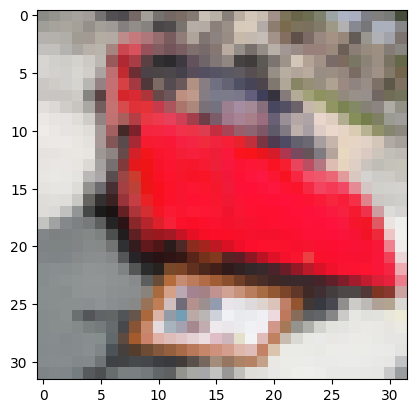

In [38]:
print(f"Class ID: {train_labels['labels'][0]}")
print(f"Box Coordinates: {train_labels['boxes'][0]}")
img = train_features[0]
#to_pil = transforms.ToPILImage()
#img_pil = to_pil(img)
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()